In [82]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

First let's work from real data to chromophores. To create some fake data, let's just use random noise for both wavelengths for now, using a dc offset for both so we don't get values <0 and a slight offset between them so we can see them in plots more distinctly.

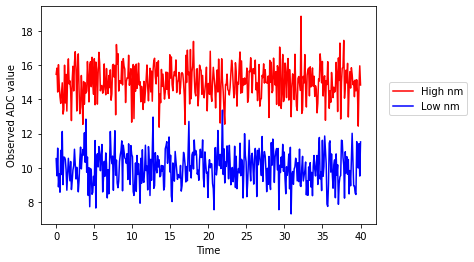

In [119]:
#generate time vector
samples_per_sec = 10.0
total_time = 40.0
time = np.linspace(0, total_time, int(total_time*samples_per_sec))

#generate fake data
hi_adc = 15 + np.random.standard_normal(len(time))
lo_adc = 10 + np.random.standard_normal(len(time))

#plot
plt.plot(time, hi_adc, 'r');
plt.plot(time, lo_adc, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Observed ADC value");

Now let's compute optical density for each wavelength:

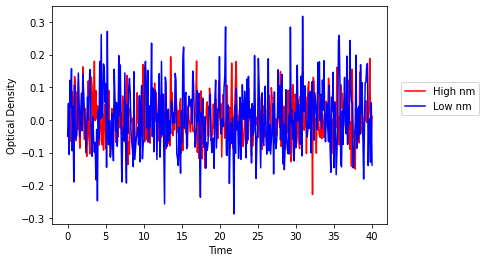

In [120]:
hi_od = np.log( np.mean(hi_adc) ) - np.log(hi_adc)
lo_od = np.log( np.mean(lo_adc) ) - np.log(lo_adc)

plt.plot(time, hi_od, 'r');
plt.plot(time, lo_od, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Optical Density");

Next we scale the optical density by the emitter-to-detector distance, which itself is multiplied by the differential pathlength factor, which is wavelength ang age specific. Let's assume the wavelengths are 750 & 850, the participant age is 30 and the emitter-to-detector distance is 3cm.

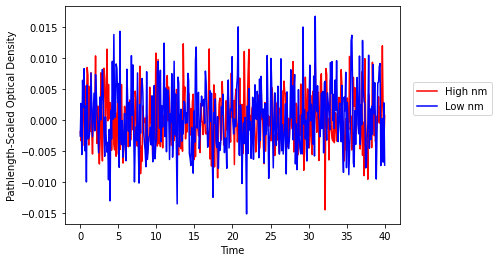

In [121]:
#define a function to compute dpf given nm & age, as per Scholkmann and
# Wolf (2013) , equation 5
def get_dpf(nm,age=0):
    return(223.3 + (0.05624)*(age**0.8493) + (-5.723e-7)*(nm**3) + (0.001245)*(nm**2) + (-0.9025)*(nm))

dist = 3.0
age = 30.0
hi_nm = 850.0
lo_nm = 750.0

dist_by_dpf_hi = dist * get_dpf(hi_nm,age)
dist_by_dpf_lo = dist * get_dpf(lo_nm,age)

scaled_hi_od = hi_od / dist_by_dpf_hi
scaled_lo_od = lo_od / dist_by_dpf_lo

plt.plot(time, scaled_hi_od, 'r');
plt.plot(time, scaled_lo_od, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Pathlength-Scaled Optical Density");

Now we convert from the pathlength-scaled optical densities to chromophores by use of the extinction coefficients for the wavelengths used:

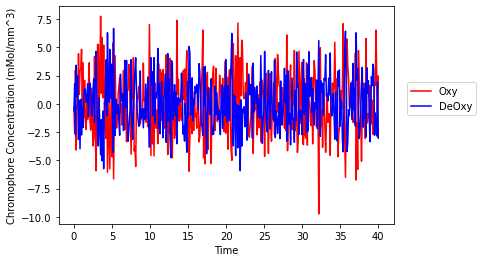

In [122]:
#I know there's matrix math to do this that's arguably better, but I could keep track of things this way easier

#extinction coefficients from first table in Homer's GetExtinctions.m
ext_oxy_hi = 1097.0 #extinction coefficient for oxy at the hi (850nm) wavelength
ext_dox_hi = 781.0
ext_oxy_lo = 600.0
ext_dox_lo = 1532.0

#multiply by 2.303 and divide by 1e6 to place on mMol/mm^3 scale
alpha_oxy_hi = ext_oxy_hi*2.303/1e6
alpha_dox_hi = ext_dox_hi*2.303/1e6
alpha_oxy_lo = ext_oxy_lo*2.303/1e6
alpha_dox_lo = ext_dox_lo*2.303/1e6

#compute the numerators
oxy_num = ( alpha_dox_lo*scaled_hi_od - alpha_dox_hi*scaled_lo_od )
dox_num = ( alpha_oxy_lo*scaled_hi_od - alpha_oxy_hi*scaled_lo_od )

#compute the denominators
oxy_denom = (alpha_dox_lo*alpha_oxy_hi) - (alpha_dox_hi*alpha_oxy_lo)
dox_denom = (alpha_oxy_lo*alpha_dox_hi) - (alpha_oxy_hi*alpha_dox_lo)

#combine
oxy = oxy_num / oxy_denom
dox = dox_num / dox_denom

plt.plot(time, oxy, 'r');
plt.plot(time, dox, 'b');
plt.legend(['Oxy', 'DeOxy'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Chromophore Concentration (mMol/mm^3)");

Ok, given the above procedure for going from observed data to chromophores, let's now try to do the reverse and check that we get back the original input data:

In [123]:
#I worked this out by hand, and found it useful to use single-letter variable names:
a = oxy
b = dox
e = alpha_dox_lo
f = alpha_dox_hi
g = oxy_denom
h = alpha_oxy_lo
i = alpha_oxy_hi
j = dox_denom

scaled_lo_od_recovered = (a*g/e*h/i - b*j/i)/(1-f/e*h/i)
scaled_hi_od_recovered = a*g/e + f/e*((a*g/e*h/i - b*j/i)/(1-f/e*h/i))

#check that there is minimal recovery error (as a proportion of expected):
print([
    np.max((scaled_lo_od_recovered-scaled_lo_od)/scaled_lo_od),
    np.max((scaled_hi_od_recovered-scaled_hi_od)/scaled_hi_od)
])


[1.1976500528374172e-14, 1.3121335000984135e-14]


And working further forward to optical density:

In [124]:
hi_od_recovered = scaled_hi_od_recovered * dist_by_dpf_hi
lo_od_recovered = scaled_lo_od_recovered * dist_by_dpf_lo

#check that there is minimal recovery error (as a proportion of expected):
print([
    np.max((hi_od_recovered-hi_od)/hi_od),
    np.max((lo_od_recovered-lo_od)/lo_od),
])

[1.3093860309882635e-14, 1.1902973774862923e-14]


Now finally a critical bit, conversion from optical density to observed ADC, which involves specifying a reference. In the conversion from observed data to chromophores above, we used the mean ADC value as the reference, so let's use that here even though it's a bit odd (since we're now pretending not to have seen the observed data and trying to infer what the observed chromophores imply we should observe for data):

In [125]:
hi_adc_recovered = np.exp( np.log(np.mean(hi)) - hi_od_recovered )
lo_adc_recovered = np.exp( np.log(np.mean(lo)) - lo_od_recovered )

#check that there is minimal recovery error (as a proportion of expected):
print([
    np.max((hi_adc_recovered-hi_adc)/hi_adc),
    np.max((lo_adc_recovered-lo_adc)/lo_adc),
])
#a bit higher error, but that's expected amidst machine precision and exponentiation


[-0.005280647988109836, -0.002341871632650929]


Great! So now that we've established how to go both from ADC values to chromophores and from chromophores to ADC values, let's go back and start with a BOLD-like chromophore timeseries, and work forward to what we should expect in terms of ADC values:

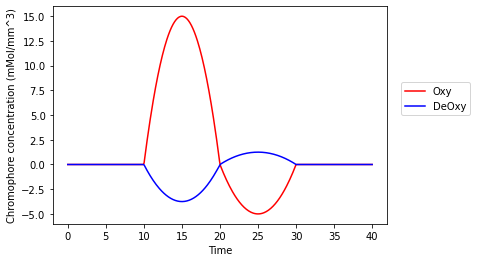

In [196]:
#for brevity, using a beta pdf to make a BOLD-like timecourse
oxy_BOLD = stats.beta(2, 2).pdf((time-10)/10) - stats.beta(2, 2).pdf((time-20)/10) / 3
oxy_BOLD *= 10 #tend to observe BOLD effects on the order of 10-30 mMol/mm^3
dox_BOLD = -oxy_BOLD/4 #deoxy tends to be smaller in magnitude and opposite sign

plt.plot(time, oxy_BOLD, 'r');
plt.plot(time, dox_BOLD, 'b');
plt.legend(['Oxy', 'DeOxy'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Chromophore concentration (mMol/mm^3)");

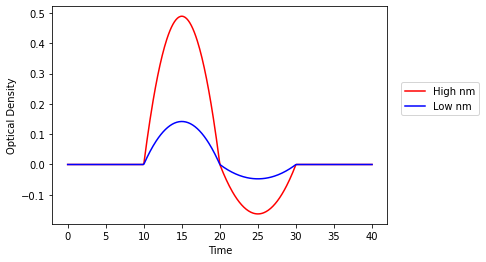

In [197]:
a = oxy_BOLD
b = dox_BOLD
scaled_lo_od_BOLD = (a*g/e*h/i - b*j/i)/(1-f/e*h/i)
scaled_hi_od_BOLD = a*g/e + f/e*((a*g/e*h/i - b*j/i)/(1-f/e*h/i))
hi_od_BOLD = scaled_hi_od_BOLD * dist_by_dpf_hi
lo_od_BOLD = scaled_lo_od_BOLD * dist_by_dpf_lo

plt.plot(time, hi_od_BOLD, 'r');
plt.plot(time, lo_od_BOLD, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Optical Density");

Now, before we do the final step of converting from optical density to observed ADC values, we have to choose the reference value as before. Let's arbitrarily use the value 1 for both wavelengths:

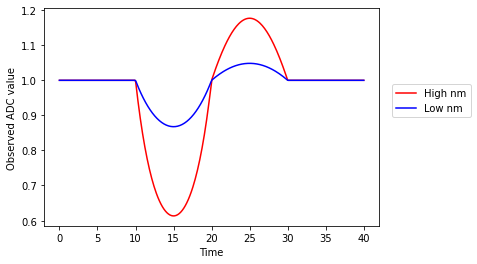

In [198]:
hi_adc_BOLD_1 = np.exp( np.log(1) - hi_od_BOLD )
lo_adc_BOLD_1 = np.exp( np.log(1) - lo_od_BOLD )

plt.plot(time, hi_adc_BOLD_1, 'r');
plt.plot(time, lo_adc_BOLD_1, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Observed ADC value");

What happens if we use a different reference value, say 100?

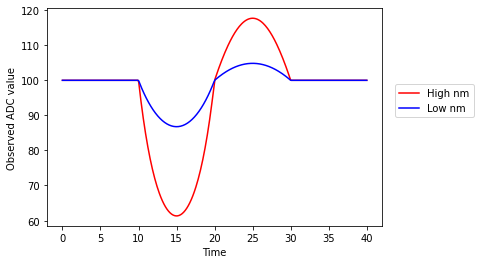

In [199]:
hi_adc_BOLD_1e2 = np.exp( np.log(100) - hi_od_BOLD )
lo_adc_BOLD_1e2 = np.exp( np.log(100) - lo_od_BOLD )

plt.plot(time, hi_adc_BOLD_1e2, 'r');
plt.plot(time, lo_adc_BOLD_1e2, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Observed ADC value");

Same shape, but the y-axis has shifted and increased in range by 100. This makes sense given the exponentiation makes for a multiplicative influence of the choice of reference when going forward. 

However, this model implies that the range of the signal should be tied to the overall mean of the signal, but this is generally not what we observe in practice. That is, I tend to observe a very large mean (around 1000), but a very small range (around 10) even when contamination signals like pulse are present (thereby expanding the range beyond that caused by the BOLD signal).

I think what happens in real data is that only a fraction of the received light has interacted with the chromophores. If this is 1% and the observed mean ADC value is 1000, this yields data with a realistic offset and range:

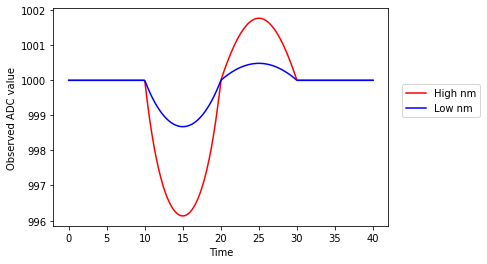

In [200]:
mean_adc_value = 1000
prop_interaction = .01
hi_adc_BOLD_1e3_1 = np.exp( np.log(mean_adc_value*prop_interaction) - hi_od_BOLD ) + mean_adc_value - mean_adc_value*prop_interaction
lo_adc_BOLD_1e3_1 = np.exp( np.log(mean_adc_value*prop_interaction) - lo_od_BOLD ) + mean_adc_value - mean_adc_value*prop_interaction

plt.plot(time, hi_adc_BOLD_1e3_1, 'r');
plt.plot(time, lo_adc_BOLD_1e3_1, 'b');
plt.legend(['High nm', 'Low nm'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Observed ADC value");

Ignoring this problem and working back to chromophores yields:

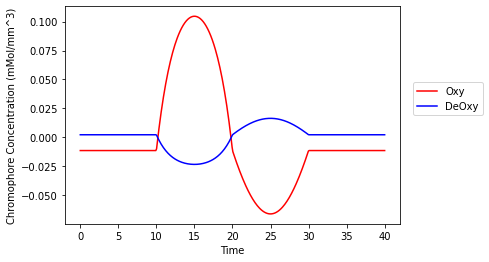

In [201]:
hi_od_BOLD_1e3_1 = np.log( np.mean(hi_adc_BOLD_1e3_1) ) - np.log(hi_adc_BOLD_1e3_1)
lo_od_BOLD_1e3_1 = np.log( np.mean(lo_adc_BOLD_1e3_1) ) - np.log(lo_adc_BOLD_1e3_1)

scaled_hi_od_BOLD_1e3_1 = hi_od_BOLD_1e3_1 / dist_by_dpf_hi
scaled_lo_od_BOLD_1e3_1 = lo_od_BOLD_1e3_1 / dist_by_dpf_lo

oxy_num_BOLD_1e3_1 = ( alpha_dox_lo*scaled_hi_od_BOLD_1e3_1 - alpha_dox_hi*scaled_lo_od_BOLD_1e3_1 )
dox_num_BOLD_1e3_1 = ( alpha_oxy_lo*scaled_hi_od_BOLD_1e3_1 - alpha_oxy_hi*scaled_lo_od_BOLD_1e3_1 )

oxy_denom_BOLD_1e3_1 = (alpha_dox_lo*alpha_oxy_hi) - (alpha_dox_hi*alpha_oxy_lo)
dox_denom_BOLD_1e3_1 = (alpha_oxy_lo*alpha_dox_hi) - (alpha_oxy_hi*alpha_dox_lo)

oxy_BOLD_1e3_1 = oxy_num_BOLD_1e3_1 / oxy_denom_BOLD_1e3_1
dox_BOLD_1e3_1 = dox_num_BOLD_1e3_1 / dox_denom_BOLD_1e3_1

plt.plot(time, oxy_BOLD_1e3_1, 'r');
plt.plot(time, dox_BOLD_1e3_1, 'b');
plt.legend(['Oxy', 'DeOxy'], loc=(1.04,.5));
plt.xlabel("Time");
plt.ylabel("Chromophore Concentration (mMol/mm^3)");

Ignoring the minor shift in the y-axis (induced by using the mean as a reference amidst an asymmetric timeseries), notice that the y-axis is dramatically smaller than the original BOLD chromophore graph. Indeed, it is about 1% the expected size thanks to the 1% interaction:

In [202]:
print(np.ptp(oxy_BOLD_1e3_1)/np.ptp(oxy_BOLD)*100)

0.853009820613348


If the interaction were 2%, the y axis would be about 2% the expected range:

In [203]:
mean_adc_value = 1000
prop_interaction = .02
hi_adc_BOLD_1e3_2 = np.exp( np.log(mean_adc_value*prop_interaction) - hi_od_BOLD ) + mean_adc_value - mean_adc_value*prop_interaction
lo_adc_BOLD_1e3_2 = np.exp( np.log(mean_adc_value*prop_interaction) - lo_od_BOLD ) + mean_adc_value - mean_adc_value*prop_interaction
hi_od_BOLD_1e3_2 = np.log( np.mean(hi_adc_BOLD_1e3_2) ) - np.log(hi_adc_BOLD_1e3_2)
lo_od_BOLD_1e3_2 = np.log( np.mean(lo_adc_BOLD_1e3_2) ) - np.log(lo_adc_BOLD_1e3_2)

scaled_hi_od_BOLD_1e3_2 = hi_od_BOLD_1e3_2 / dist_by_dpf_hi
scaled_lo_od_BOLD_1e3_2 = lo_od_BOLD_1e3_2 / dist_by_dpf_lo

oxy_num_BOLD_1e3_2 = ( alpha_dox_lo*scaled_hi_od_BOLD_1e3_2 - alpha_dox_hi*scaled_lo_od_BOLD_1e3_2 )
dox_num_BOLD_1e3_2 = ( alpha_oxy_lo*scaled_hi_od_BOLD_1e3_2 - alpha_oxy_hi*scaled_lo_od_BOLD_1e3_2 )

oxy_denom_BOLD_1e3_2 = (alpha_dox_lo*alpha_oxy_hi) - (alpha_dox_hi*alpha_oxy_lo)
dox_denom_BOLD_1e3_2 = (alpha_oxy_lo*alpha_dox_hi) - (alpha_oxy_hi*alpha_dox_lo)

oxy_BOLD_1e3_2 = oxy_num_BOLD_1e3_2 / oxy_denom_BOLD_1e3_2
dox_BOLD_1e3_2 = dox_num_BOLD_1e3_2 / dox_denom_BOLD_1e3_2

print(np.ptp(oxy_BOLD_1e3_2)/np.ptp(oxy_BOLD)*100)

1.7079969357962816


I'm actually not sure why these ranges aren't precisely `prop_interaction*expected_range`. I suspect that if there is a solution to all this, working out this relationship will be important. But for now, I think the above at least demostrates that something is missing in the conventional treatment of the chromophore conversion process. My experience with real data is such that I see high mean ADC values but narrow ranges, and this can (only?) be accounted for by a model whereby only a small fraction of the light actually interacts with the chromophores. When this is the case and one uses conventional conversion, this induces a rescaling of the resulting chromophores relative to what they should be.

In theory, we might be able to assume that the `prop_interaction` parameter is constant for a given location, in which noise from trial to trial should still be susceptible to the central limit theorem and the estimated mean chromophore timeseries should still approximate the true mean chromophore timeseries. However I don't think we can assume that `prop_interaction` is constant across locations nor across participants, in which case variability in `prop_interaction` is going to induce much more variability in the chromophore timeseries. I'm also not certain that the CLT applies here, as there is a non-linear transform when computing optical density and CLT only applies when computations are linear. 

When it comes to solutions, I suspect that this is a ill-posed problem such that we'll need to use other sources of information to constrain estimates of `prop_interaction`. I really don't have any intuitions on the way forward beyond that however.